# TO GRANT OR NOT TO GRANT: DECIDING ON COMPENSATION BENEFITS

## 1. Imports, options and ingestion

In [17]:
# importing the libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import re
import math

In [18]:
# setting the options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=np.inf)
plt.style.use('seaborn-v0_8-dark')

In [19]:
# importing the training and test data
df = pd.read_csv('/home/shadybea/OneDrive/General/Machine Learning/Project/Data/train_data.csv', sep=',')
df_test = pd.read_csv('/home/shadybea/OneDrive/General/Machine Learning/Project/Data/test_data.csv', sep=',')


/tmp/ipykernel_5920/2449055217.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/shadybea/OneDrive/General/Machine Learning/Project/Data/train_data.csv', sep=',')


Just by importing the dataset, we get a warning saying column 29 has mixed data types - we will check this in a bit.

## 2. Initial inspection

### 2.1. Macro-inspection

In [ ]:
# we check the shape of the dataset
df.shape

In [ ]:
# we check the first rows of the dataset
df.head()

In [ ]:
# we check if there are any aggregation rows at the end of the dataset
df.tail()

In [ ]:
# we check the datatypes and null counts
df.info()

**Data type analysis:**

Features that should be integers:
- 'Age at Injury'
- 'Birth Year'
- 'IME-4 Count'
- 'Industry Code'
- 'WCIO Cause of Injury Code'
- 'WCIO Nature of Injury Code'
- 'WCIO Part Of Body Code'
- 'Number of Dependents'

Features that should be booleans:
- 'Agreement Reached'

### 2.2. Claim Identifier

This feature is the unique identifier of each claim - we will analyse this column in more depth in an attempt to assign it as the index of our dataframe.

In [ ]:
# we check if there are any duplicate values for this column
df[df['Claim Identifier'].duplicated(keep=False)]

Apparently, we have one duplicated 'Claim Identifier', where all values, except for 'Assembly Date', are NaNs. </br>
We will use the default python behavior and drop the second appearence of the repeated 'Claim Identifier'. </br>
As we saw previously, this column has no null values, so we can set it as the dataframe index.

In [20]:
df = df[~df['Claim Identifier'].duplicated()].set_index('Claim Identifier').rename_axis(None)

In [ ]:
df.head()

### 2.3. Data consistency

#### 2.3.1. Missing Values

In [ ]:
# Calculate the number of NaNs for each column
nan_counts = df.isna().sum()

# Get the total number of rows (entries) in the DataFrame
total_rows = df.shape[0]

# Calculate the percentage of NaN values for each column
percentage_nans = (nan_counts / total_rows) * 100

# Format the percentage with '%' sign
percentage_nans = percentage_nans.apply(lambda x: f"{x:.2f}%")

# Combine all information into a DataFrame for better readability
nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Total Values': [total_rows] * len(nan_counts),  # Ensure this column matches the length of nan_counts
    'Percentage NaN': percentage_nans
})

# Print the result
print("Summary of NaN values per column:\n")
print(nan_summary)

By analysing the output above, we conclude:
- **'C-3 Date'**: more than 50% of the data for this feature is missing, it can be due to process status - the employee has not yet sent its report
- **'First Hearing Date'**: around 75% of the data for this feature is missing - this means hearings have not yet been scheduled
- **'IME-4 Count'**: more than 75% of the data for this feature is missing, it can be due to process status - the independent examiner has not yet sent its report
- **'OIICS Nature of Injury Description'**: only has null values

##### 2.3.1.1. Accident Date

We have a few missing values for 'Accident Date'; however, these values can be imputed if we have information about 'Age at Injury' and 'Birth Year'

In [ ]:
df['Accident Date'].isna().sum()

In [ ]:
df[(df['Accident Date'].isna()) & ~((df['Age at Injury'].isna()) | (df['Age at Injury'] == 0.0)) & ~(df['Birth Year'].isna())]

We have no way of deducing missing values for 'Accident Date'.

##### 2.3.1.2. Age at Injury

We have a few missing values for 'Age at Injury'; however, these values can be imputed if we have information about 'Accident Date' and 'Birth Year'

In [ ]:
df['Age at Injury'].isna().sum()

In [ ]:
df[(df['Age at Injury'].isna()) & ~((df['Accident Date'].isna())) & ~(df['Birth Year'].isna())]

We have no way of deducing missing values for 'Age at Injury'

##### 2.3.1.3. Birth Year

We have a few missing values for 'Birth Year'; however, these values can be imputed if we have information about 'Accident Date' and 'Age at Injury'

In [ ]:
df['Birth Year'].isna().sum()

In [ ]:
df[(df['Birth Year'].isna()) & ~((df['Accident Date'].isna())) & ~(df['Age at Injury'].isna())]

We will be able to deduce a good amount of values for 'Birth Year'. </br>
We do this in section TK.

#### 2.3.2. Data types

As we imported the data, we got a warning saying columns had mixed data types. We shall take a look at this issue now.

In [ ]:
def check_mixed_types(column):
    return len(set(column[pd.notna(column)].apply(type))) > 1  # If there are more than one unique data types, excluding NaN values (as these are considered as floats)

# Apply the function to all columns and filter out the mixed-type columns
mixed_type_columns = [col for col in df.columns if check_mixed_types(df[col])]

print(mixed_type_columns)

In [ ]:
for col in mixed_type_columns:
    print(df[col].apply(type).value_counts())

The values for 'Zip Code' are split across two data types - string and float. We shall look at the feature values in order to make a decision.

In [ ]:
# we check if there are any values that contain any non numeric character
print(df[df['Zip Code'].apply(lambda x: bool(re.search(r'\D', str(x))))]['Zip Code'].unique())

Since we have determined that there are values for 'Zip Code' that contain other than numeric characters, we shall set this feature as a string.

In [21]:
# Changing the data type of the values to string
df['Zip Code'] = df['Zip Code'].astype(str)

In [ ]:
# re-checking the data type counts
print(df['Zip Code'].apply(type).value_counts())

Let us now fixed the remaining data types, as identified in [Section 2.1](#21-macro-inspection)

In [22]:
features_to_cast = ['Age at Injury', 'Birth Year', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Number of Dependents', 'Agreement Reached']

In [23]:
for feature in features_to_cast:
    df[feature] = pd.to_numeric(df[feature], errors='coerce').astype('Int64')

In [ ]:
# checking if the conversion was successful
for feature in features_to_cast:
    print(feature, '\t', df[feature].dtypes)

#### 2.3.4. Unique values

In [ ]:
# we check the number of unique values for each column
df.nunique()

In [ ]:
# we check the unique values for each column
pd.DataFrame(
    {
        'feature_type': [df[column].dtype for column in df.columns],
        'unique_values': df.apply(lambda col: sorted(pd.Series(col.dropna().unique().tolist())))  # we disregard NaN values, so we can sort the unique values
    }
)

Looking at this information, we can point out the following:
- **Age at Injury**: since this dataset concerns workplace injuries, values under 14 (legal working age in the US) are weird
- **Birth Year**: we have '0.0' values
- **OIICS Nature of Injury Description**: has no values
- **WCIO Part Of Body Code**: has a negative value
- **WCB Decision**: only has one value

#### 2.3.5. Date formats

In [24]:
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']

# regex pattern for the format YYYY-MM-DD
date_pattern = r'^\d{4}-\d{2}-\d{2}$'

# check if there are any values in these date columns that do not follow this format
for column in date_columns:
    display(df[df[column].apply(lambda x: pd.notna(x) and not bool(re.match(date_pattern, str(x))))])

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents


Since we have assessed that all dates are in the same format, we are going to transform these columns into integers with the format YYYYMMDD

In [25]:
for col in date_columns:
    # first, we convert the columns to datetime
    df[col] = pd.to_datetime(df[col])
    # then we convert it to int
    # df[col] = df[col].dt.strftime('%Y%m%d').astype('Int64')

In [ ]:
df.head()

#### 2.3.6. Inconsistencies

##### 2.3.6.1. Codes vs. Descriptions

In this section, we will check if the amount of codes are the same as the descriptions.

In [ ]:
len(df['Industry Code'].dropna().unique()) == len(df['Industry Code Description'].dropna().unique())

In [ ]:
df.groupby(['Industry Code', 'Industry Code Description']).size().reset_index(name='count').sort_values('Industry Code Description')

The "repeated" values of 'Industry Code Description' occur for consecutive 'Industry Code' values - one could consider replacing the different values for 'Industry Code' for a unique one.

In [ ]:
len(df['WCIO Cause of Injury Code'].dropna().unique()) == len(df['WCIO Cause of Injury Description'].dropna().unique())

In [ ]:
df.groupby(['WCIO Cause of Injury Code', 'WCIO Cause of Injury Description']).size().reset_index(name='count').sort_values(by='WCIO Cause of Injury Description')

Again, one could aggregate the same value for the description in the same code. There is also some values that are rather similiar that could be aggregated (e.g. 'MOVING PART OF MACHINE' and 'MOVING PARTS OF MACHINE')

In [ ]:
len(df['WCIO Nature of Injury Code'].dropna().unique()) == len(df['WCIO Nature of Injury Description'].dropna().unique())

In [ ]:
len(df['WCIO Part Of Body Code'].dropna().unique()) == len(df['WCIO Part Of Body Description'].dropna().unique())

In [ ]:
df.groupby(['WCIO Part Of Body Code', 'WCIO Part Of Body Description']).size().reset_index(name='count').sort_values(by='WCIO Part Of Body Description')

Once again, we have descriptions associated to multiple codes - we can aggregate these descriptions into one single code.

##### 2.3.6.2. The wanna-be NaN

We will check if there are NaN values that are coded as string values, instead of the default np.nan

In [ ]:
# we check if any column contains the string 'nan'
contains_nan_string = df.apply(lambda col: col.isin(['nan']).any())

# we get the columns that contain 'nan'
columns_with_nan_string = contains_nan_string[contains_nan_string].index.tolist()

columns_with_nan_string

Indeed we have string representations of missing values in 'Zip Code' - we shall convert these into actual NaN

In [26]:
df['Zip Code'] = df['Zip Code'].replace('nan', np.nan)

##### 2.3.6.3. Duplicated values

In [ ]:
# we check how many duplicated rows we have
df.duplicated(keep=False).sum()

In [ ]:
# we check how many of these are distinct
len(df[df.duplicated(keep=False)].drop_duplicates())

In fact, even though we have 19k+ duplicated rows, 1k of these rows are distinct, i.e., we have rows with more than one duplicate

In [ ]:
df[df.duplicated()].drop_duplicates().head(10)

We shall check if all values of all rows are NaN with the exception of 'Assembly Date'

In [ ]:
# we drop duplicates from those duplicated rows
unique_duplicated_rows = df[df.duplicated(keep=False)].drop_duplicates()

# we check if all values (excluding 'Assembly Date') are NaN
nan_check = unique_duplicated_rows.drop(columns='Assembly Date').isna().all(axis=1)

# we check the rows that have other than missing values
unique_duplicated_rows[~nan_check]

This means that all duplicated rows have missing values in every column but 'Assembly Date', except for one row

In [ ]:
# percentage of duplicate values
df.duplicated().sum() / df.shape[0] * 100

The duplicated (and "empty") rows we have been discussing account for around 3.1% of our data - we will drop these values.

In [27]:
df.drop_duplicates(inplace=True)

##### 2.3.6.4. The target

In [ ]:
# we check how many missing values we have in our target variable
df['Claim Injury Type'].isna().sum()

In [ ]:
df[df['Claim Injury Type'].isna()].head(10)

At a first glance, it looks like these rows are all NaN values with the exception of 'Assembly Date' - just like before. Let us check if this is indeed the case.

In [ ]:
no_target_df = df[df['Claim Injury Type'].isna()]

# we check if all values (excluding 'Assembly Date') are NaN
nan_check = no_target_df.drop(columns='Assembly Date').isna().all(axis=1)

# we check the rows that have other than missing values
no_target_df[~nan_check]

It seems like all these rows have missing values in every column but 'Assembly Date' - we will also remove these rows.

In [28]:
df = df[~df['Claim Injury Type'].isna()]

Knowing the original dataset had 593471 rows, let us check what percentage of the data we have removed so far.

In [ ]:
(1 - (df.shape[0] / 593471)) * 100

We are still below the 5% threshold rule of thumb, so we are good to go!

### 2.4. Statistical pitstop

Let us recheck our count of missing values once more and look at some statistics

### 2.4.1. Missing values (again)

In [ ]:
# Calculate the number of NaNs for each column
nan_counts = df.isna().sum()

# Get the total number of rows (entries) in the DataFrame
total_rows = df.shape[0]

# Calculate the percentage of NaN values for each column
percentage_nans = (nan_counts / total_rows) * 100

# Format the percentage with '%' sign
percentage_nans = percentage_nans.apply(lambda x: f"{x:.2f}%")

# Combine all information into a DataFrame for better readability
nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Total Values': [total_rows] * len(nan_counts),  # Ensure this column matches the length of nan_counts
    'Percentage NaN': percentage_nans
})

# Print the result
print("Summary of NaN values per column:\n")
print(nan_summary)

We have considerably reduced the number of missing values - nice!

### 2.4.2. Summary statistics

In [ ]:
df.describe(include='all').T

## 3. Visual inspection

We now start the visual inspection of our data

In [29]:
# we start by defining our numeric and categorical features
# Note: we exclude from this initial analysis all columns related with descriptions and those that are unary ('WCB Decision')
numeric_features = df[['Age at Injury', 'Average Weekly Wage', 'IME-4 Count', 'Birth Year']].columns.tolist()
date_features = df[['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']].columns.tolist()
categorical_features = df[['Alternative Dispute Resolution', 'Attorney/Representative', 
       'Carrier Type', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'Gender', 'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code', 'Agreement Reached',
       'Number of Dependents']].columns.tolist()

all_features = numeric_features + date_features + categorical_features

In [ ]:
# we check the value counts for the categorical features
for feature in categorical_features:
    print(df[feature].value_counts())

### 3.1. Histograms

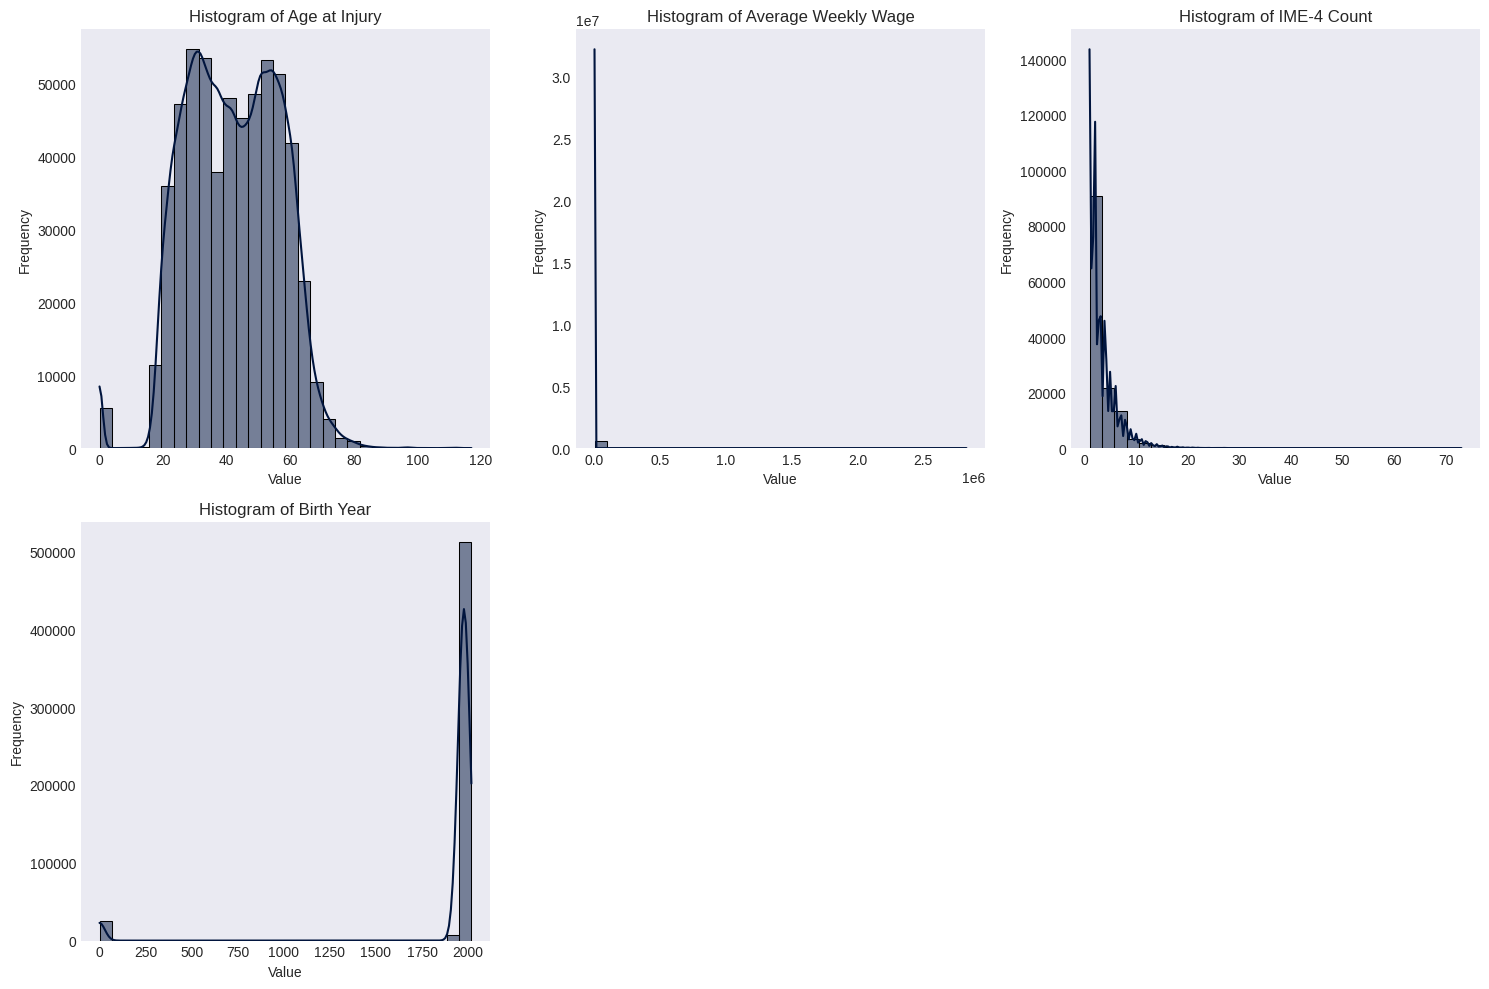

In [238]:
num_features = len(numeric_features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes array for easier iteration if there's more than one row
axes = axes.flatten()

# Loop through each numeric feature to plot histograms with Seaborn
for ax, feature in zip(axes, numeric_features):
    sns.histplot(df[feature].dropna(), bins=30, color='#01153e', kde=True, ax=ax)  # kde adds a density line
    ax.set_title(f'Histogram of {feature}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Hide any empty subplots if the number of features is not even
for i in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

It seems we have a lot of 0 values in 'Average Weekly Wage', so let us plot this variable without the 0s to get a better understanding of the underlying distribution.

In [ ]:
# wage_ = df[df['Average Weekly Wage'] != 0]['Average Weekly Wage'].dropna()

# plt.figure(figsize=(10, 6))
# sns.histplot(wage_, bins=20, kde=True)  # kde=True adds a kernel density estimate
# plt.title('Distribution of Average Weekly Wage (Excluding 0)')
# plt.xlabel('Average Weekly Wage')
# plt.ylabel('Frequency')
# plt.show()

The 0s in 'Birth Year' is also making it difficult to understand this distribution - we will plot this variable without the 0s, as these are invalid values anyway.

In [ ]:
birth_ = df[df['Birth Year'] != 0]['Birth Year']

plt.figure(figsize=(10, 6))
sns.histplot(birth_, bins=20, kde=True)  # kde=True adds a kernel density estimate
plt.title('Distribution of Birth Years (Excluding 0)')
plt.xlabel('Birth Year')
plt.ylabel('Frequency')
plt.show()

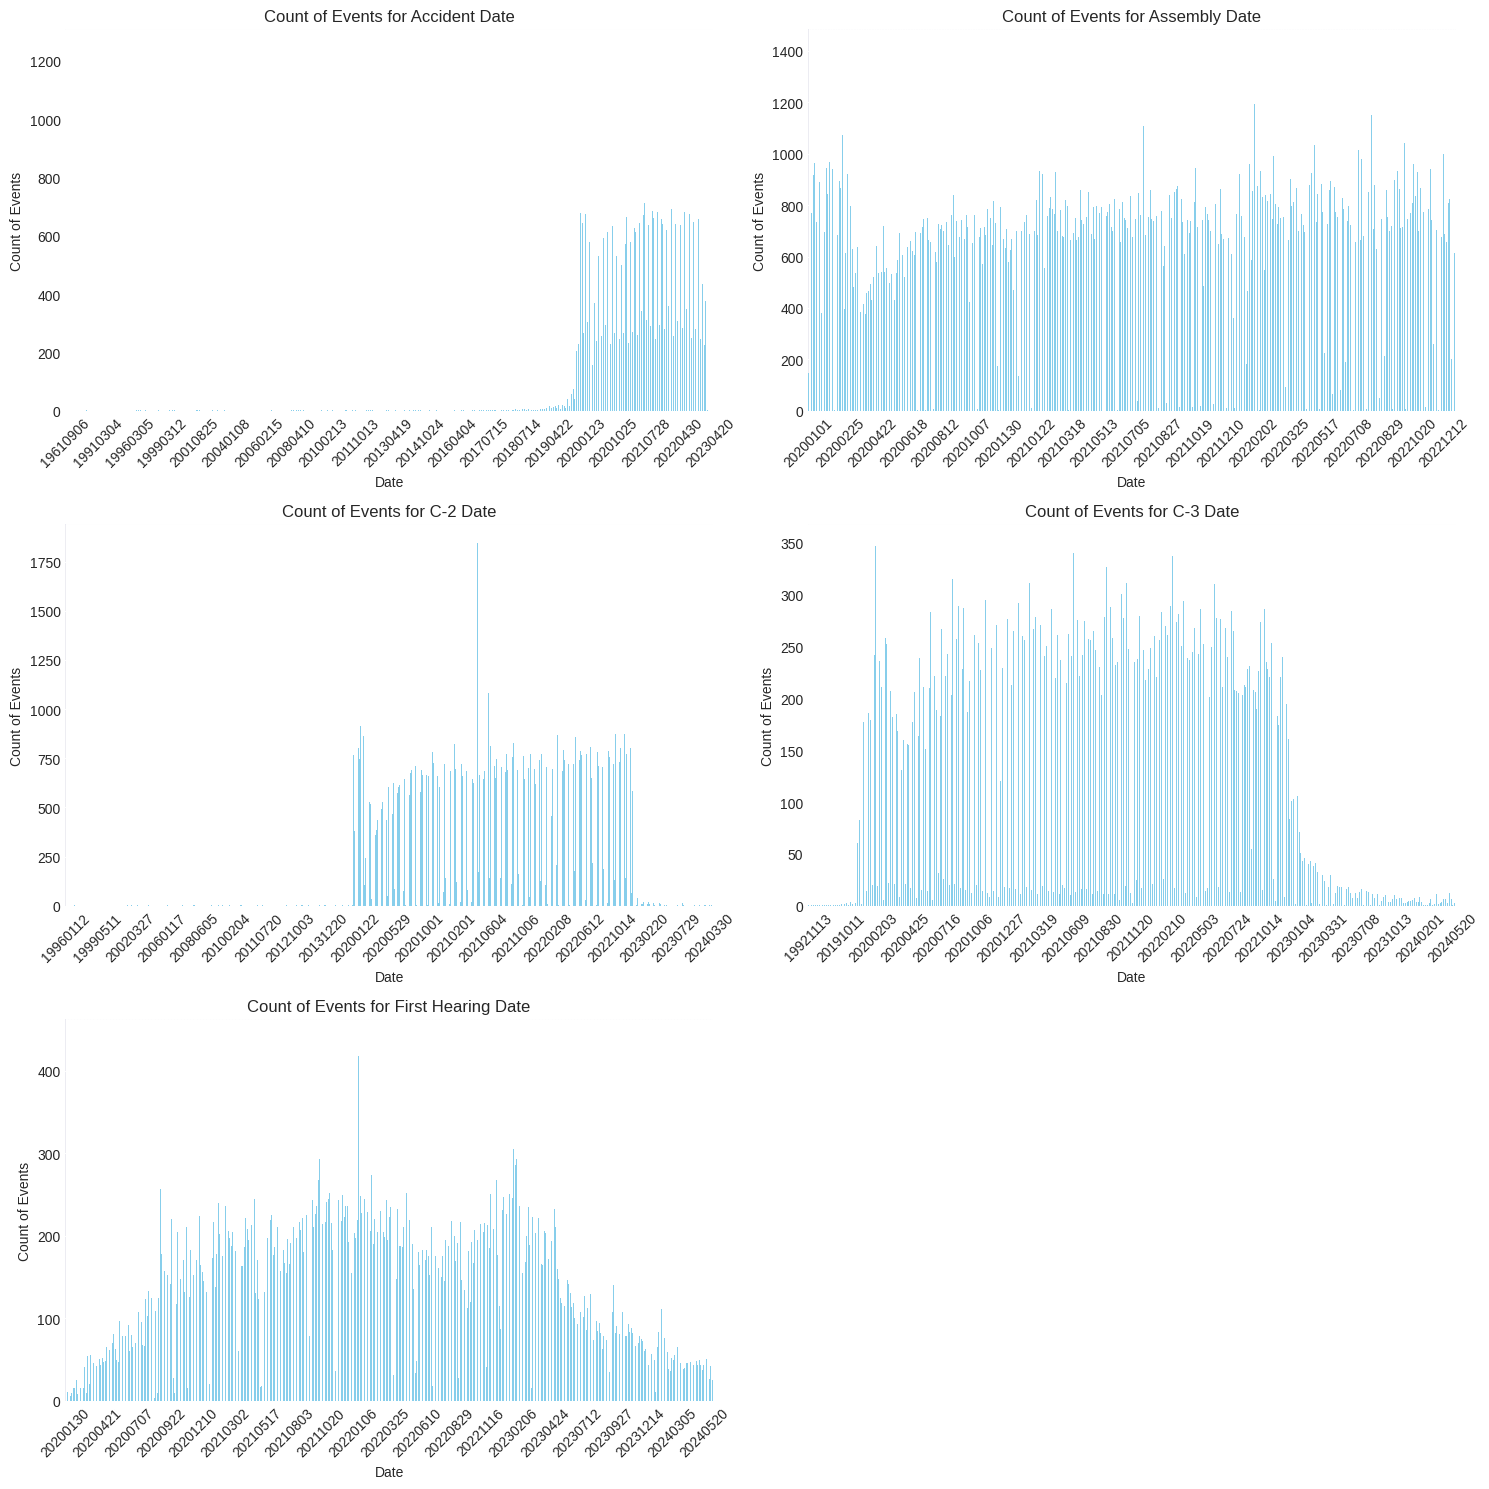

In [38]:
num_features = len(date_features)
num_columns = 2
num_rows = (num_features + num_columns - 1) // num_columns

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes array for easier iteration if there's more than one row
axes = axes.flatten()

# Loop through each date feature to plot counts
for ax, feature in zip(axes, date_features):
    # Count occurrences per date
    date_counts = df[feature].value_counts().sort_index()

    # Plotting the counts
    date_counts.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'Count of Events for {feature}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Count of Events')
    
    
    tick_indices = list(range(0, len(date_counts), max(1, len(date_counts) // 20)))
    tick_labels = [date_counts.index[i].strftime('%Y%m%d') if i in tick_indices else '' for i in range(len(date_counts))]
    ax.set_xticklabels(tick_labels, rotation=45)
    
    ax.grid()

# Hide any empty subplots if the number of features is not even
for i in range(len(date_features), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

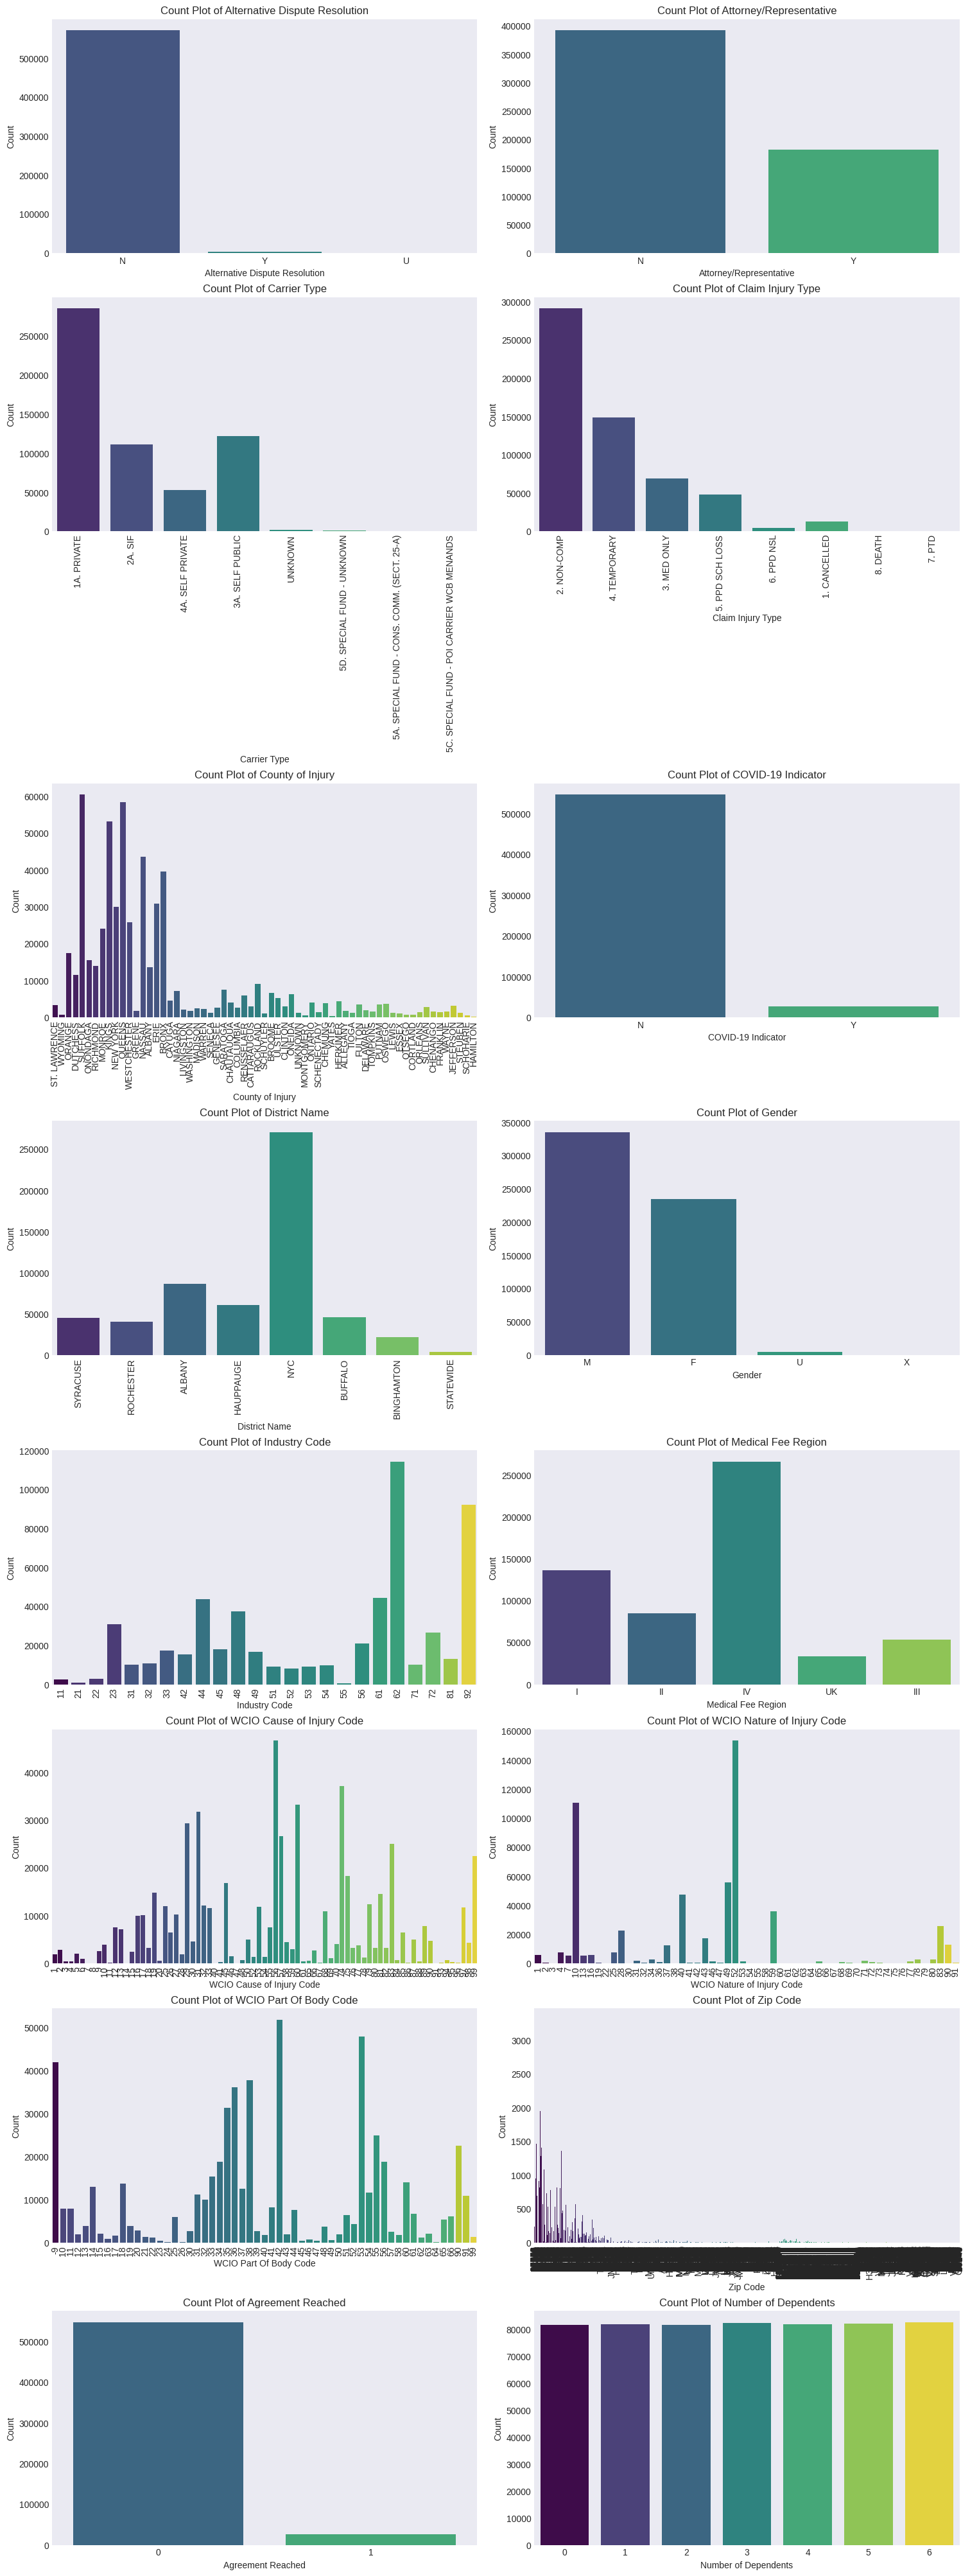

In [47]:
num_features = len(categorical_features)
num_columns = 2
num_rows = (num_features + num_columns - 1) // num_columns

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows), constrained_layout=True)

# Flatten the axes array for easier iteration if there's more than one row
axes = axes.flatten()

better_labels = ['Carrier Type', 'Claim Injury Type', 'County of Injury', 'District Name'
                 , 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code'
                 , 'WCIO Part Of Body Code', 'Zip Code']

row_label_heights = []

# Loop through each categorical feature to plot count plots with Seaborn
for i, (ax, feature) in enumerate(zip(axes, categorical_features)):
    sns.countplot(data=df, x=feature, hue=feature, ax=ax, palette='viridis', legend=False)
    ax.set_title(f'Count Plot of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

    # Rotate labels if feature in better_labels
    if feature in better_labels:
        ax.tick_params(axis='x', rotation=90)

# Hide any unused subplots if the number of features is not even
for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])

# Show the plot
plt.show()

### 3.2. Boxplots

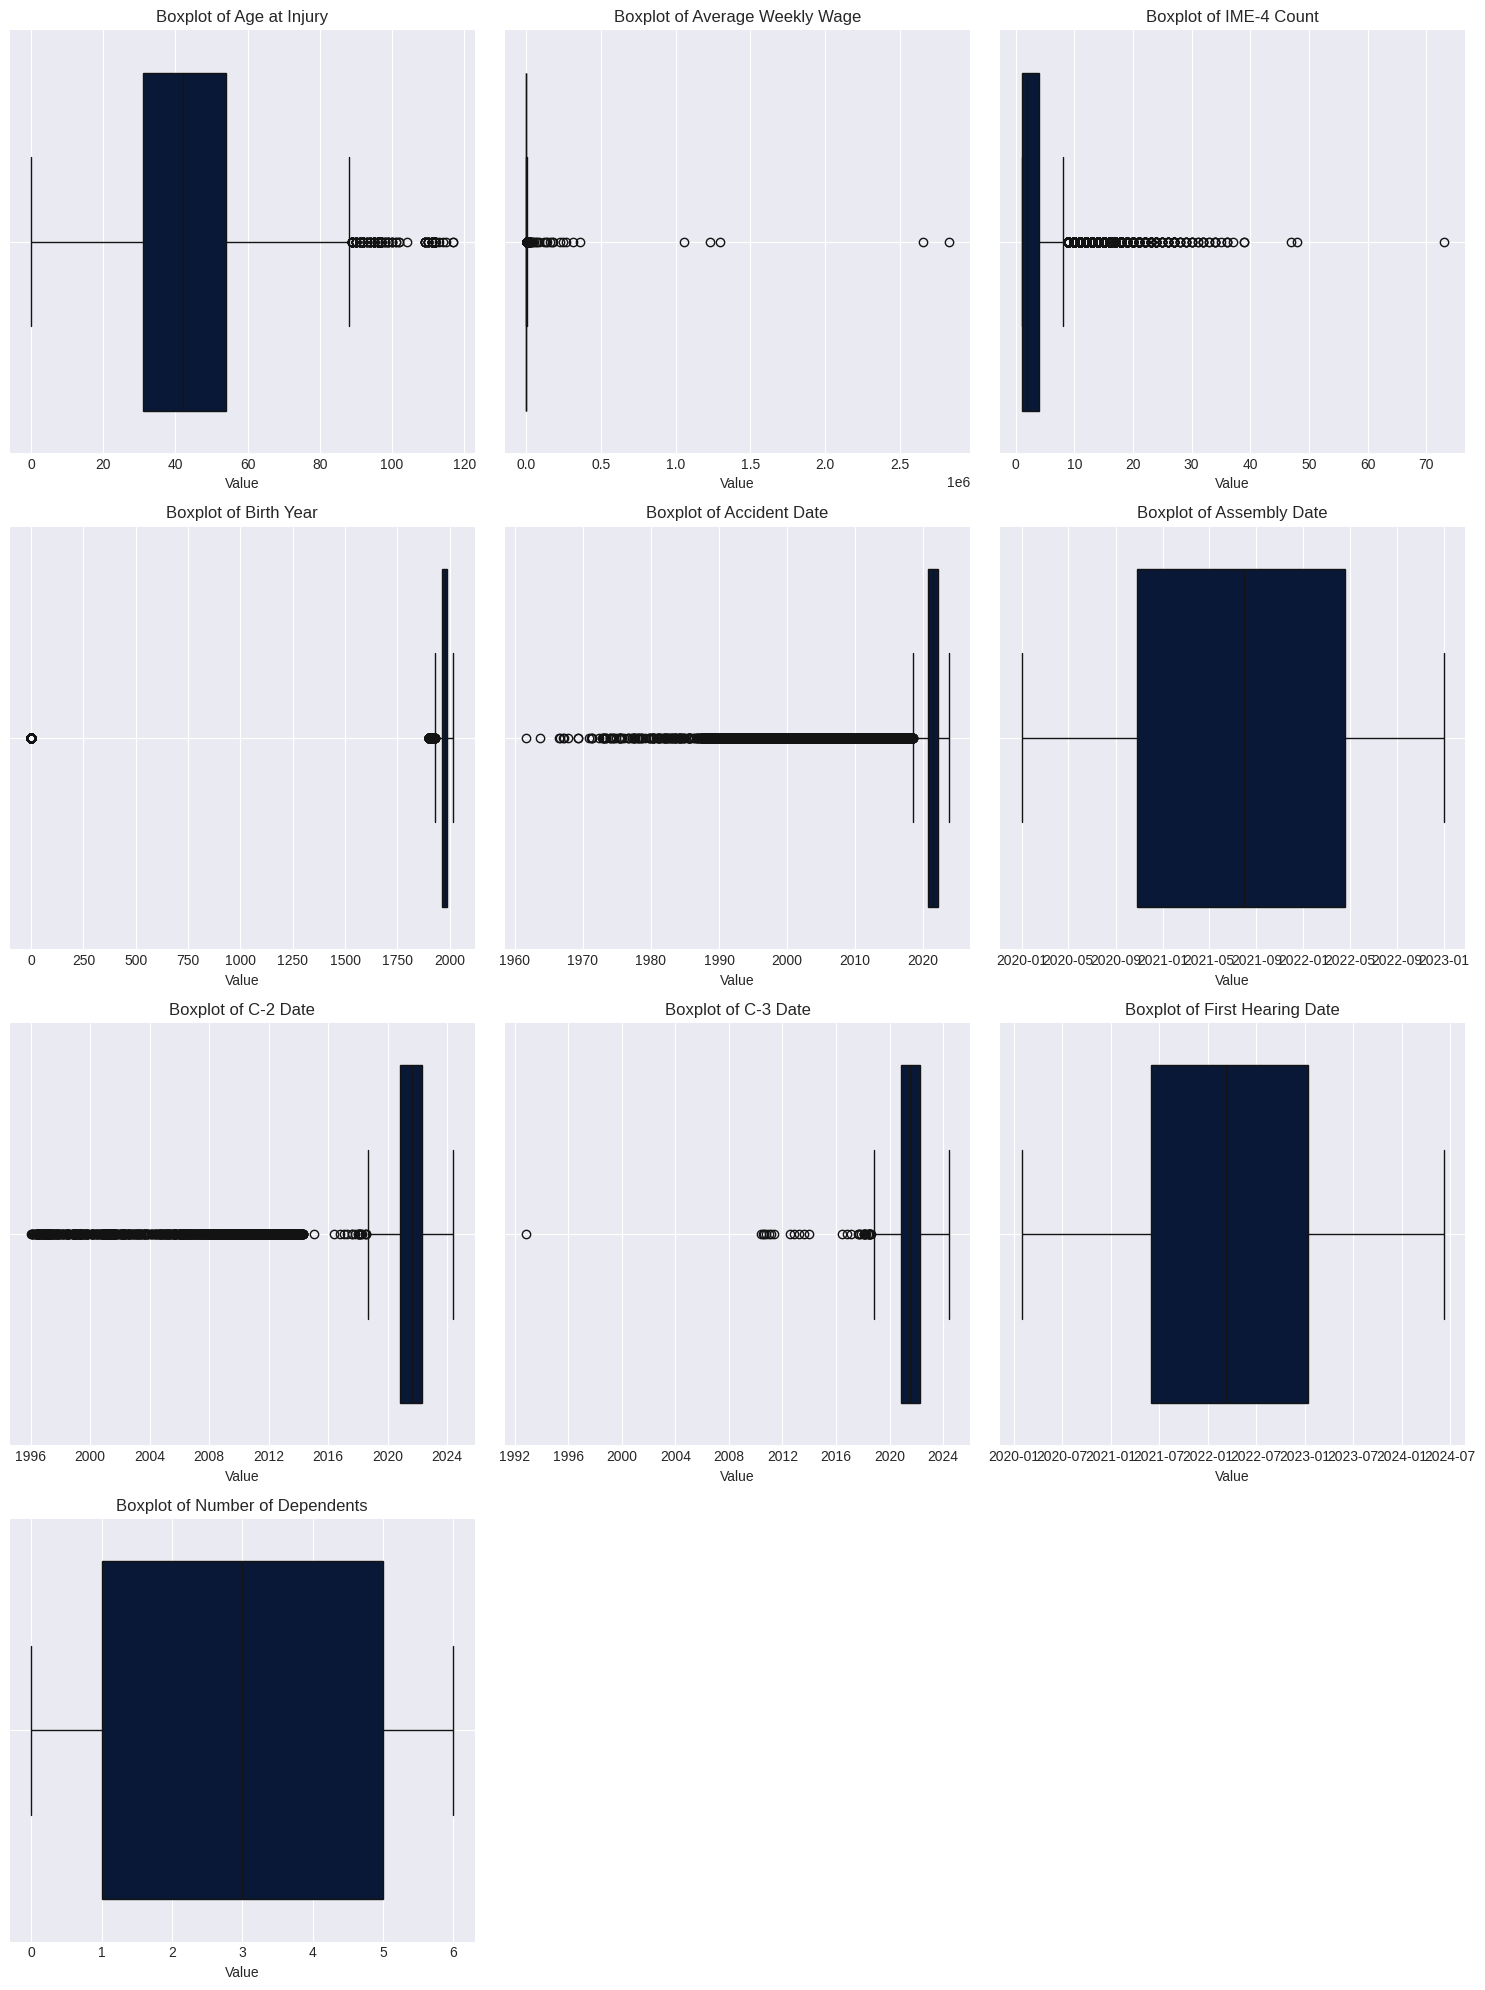

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

box_plot_features = numeric_features + date_features + ['Number of Dependents']

num_features = len(box_plot_features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes array for easier iteration if there's more than one row
axes = axes.flatten()

# Loop through each numeric feature to plot boxplots with Seaborn
for ax, feature in zip(axes, box_plot_features):
    sns.boxplot(x=df[feature], color='#01153e', ax=ax)  # Set color to match previous style
    ax.set_title(f'Boxplot of {feature}')
    ax.set_xlabel('Value')
    ax.grid(True)

# Hide any empty subplots if the number of features is not even
for i in range(len(box_plot_features), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### 3.3. Correlation matrix

#### 3.3.1. Numeric features

First, let's encode the target variable to numeric so we can plot the correlation matrix.

In [55]:
# we create a dataset with the numeric features and the target
df_corr_numeric = df[numeric_features + ['Claim Injury Type']]

In [57]:
df['Claim Injury Type'].unique()

array(['2. NON-COMP', '4. TEMPORARY', '3. MED ONLY', '5. PPD SCH LOSS',
       '6. PPD NSL', '1. CANCELLED', '8. DEATH', '7. PTD'], dtype=object)

In [58]:
# we keep only the number in the category values
df_corr_numeric['Claim Injury Type'] = df_corr_numeric['Claim Injury Type'].str[0]

/tmp/ipykernel_5920/2524329175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_numeric['Claim Injury Type'] = df_corr_numeric['Claim Injury Type'].str[0]


In [59]:
df_corr_numeric.head()

,Age at Injury,Average Weekly Wage,IME-4 Count,Birth Year,Claim Injury Type
5393875,31,0.00,<NA>,1988,2
5393091,46,1745.93,4,1973,4
5393889,40,1434.80,<NA>,1979,4
5393887,61,NaN,<NA>,1958,2
5393863,67,0.00,<NA>,1952,3


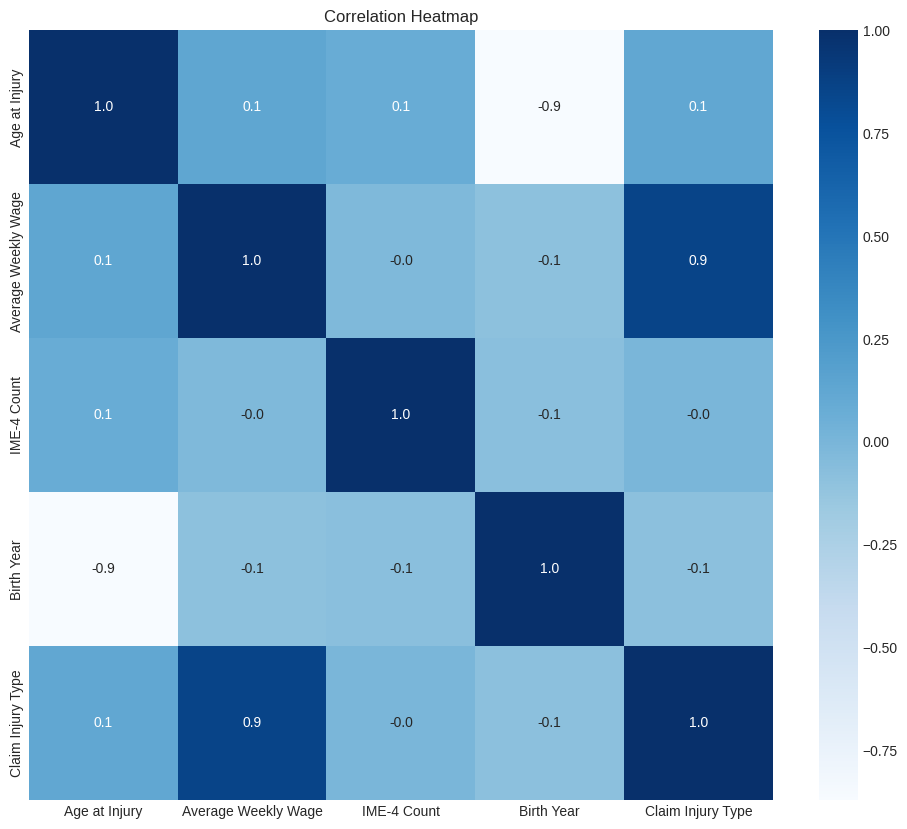

In [70]:
# Compute the correlation matrix for the numeric columns
corr_matrix = df_corr_numeric.corr(method='spearman')

# Create the heatmap
plt.figure(figsize=(12,10))
sns.heatmap(data=corr_matrix, annot=True, cmap=plt.cm.Blues, fmt='.1f')

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

Looking at this correlation matrix, we conclude that 'Average Weekly Wage' is highly correlated with the target. Also, 'Birth Year' and 'Age at Injury' are inversely correlated.

#### 3.3.2. Date features

Let us split the date columns into its components: Year, Month and Day

In [72]:
df_corr_dates = df[date_features]

for col in date_features:
    df_corr_dates[f'{col} Year'] = df[col].dt.year
    df_corr_dates[f'{col} Month'] = df[col].dt.month
    df_corr_dates[f'{col} Day'] = df[col].dt.day

/tmp/ipykernel_5920/2644712111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_dates[f'{col} Year'] = df[col].dt.year
/tmp/ipykernel_5920/2644712111.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_dates[f'{col} Month'] = df[col].dt.month
/tmp/ipykernel_5920/2644712111.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [73]:
df_corr_dates['Claim Injury Type'] = df['Claim Injury Type'].str[0]

/tmp/ipykernel_5920/166114864.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_dates['Claim Injury Type'] = df['Claim Injury Type'].str[0]


In [74]:
df_corr_dates.head()

,Accident Date,Assembly Date,C-2 Date,C-3 Date,First Hearing Date,Accident Date Year,Accident Date Month,Accident Date Day,Assembly Date Year,Assembly Date Month,Assembly Date Day,C-2 Date Year,C-2 Date Month,C-2 Date Day,C-3 Date Year,C-3 Date Month,C-3 Date Day,First Hearing Date Year,First Hearing Date Month,First Hearing Date Day,Claim Injury Type
5393875,2019-12-30,2020-01-01,2019-12-31,NaT,NaT,2019.0,12.0,30.0,2020,1,1,2019.0,12.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,2
5393091,2019-08-30,2020-01-01,2020-01-01,2020-01-14,2020-02-21,2019.0,8.0,30.0,2020,1,1,2020.0,1.0,1.0,2020.0,1.0,14.0,2020.0,2.0,21.0,4
5393889,2019-12-06,2020-01-01,2020-01-01,NaT,NaT,2019.0,12.0,6.0,2020,1,1,2020.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4
5393887,2019-12-30,2020-01-01,2019-12-31,NaT,NaT,2019.0,12.0,30.0,2020,1,1,2019.0,12.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,2
5393863,2019-12-26,2020-01-01,2019-12-31,NaT,NaT,2019.0,12.0,26.0,2020,1,1,2019.0,12.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,3


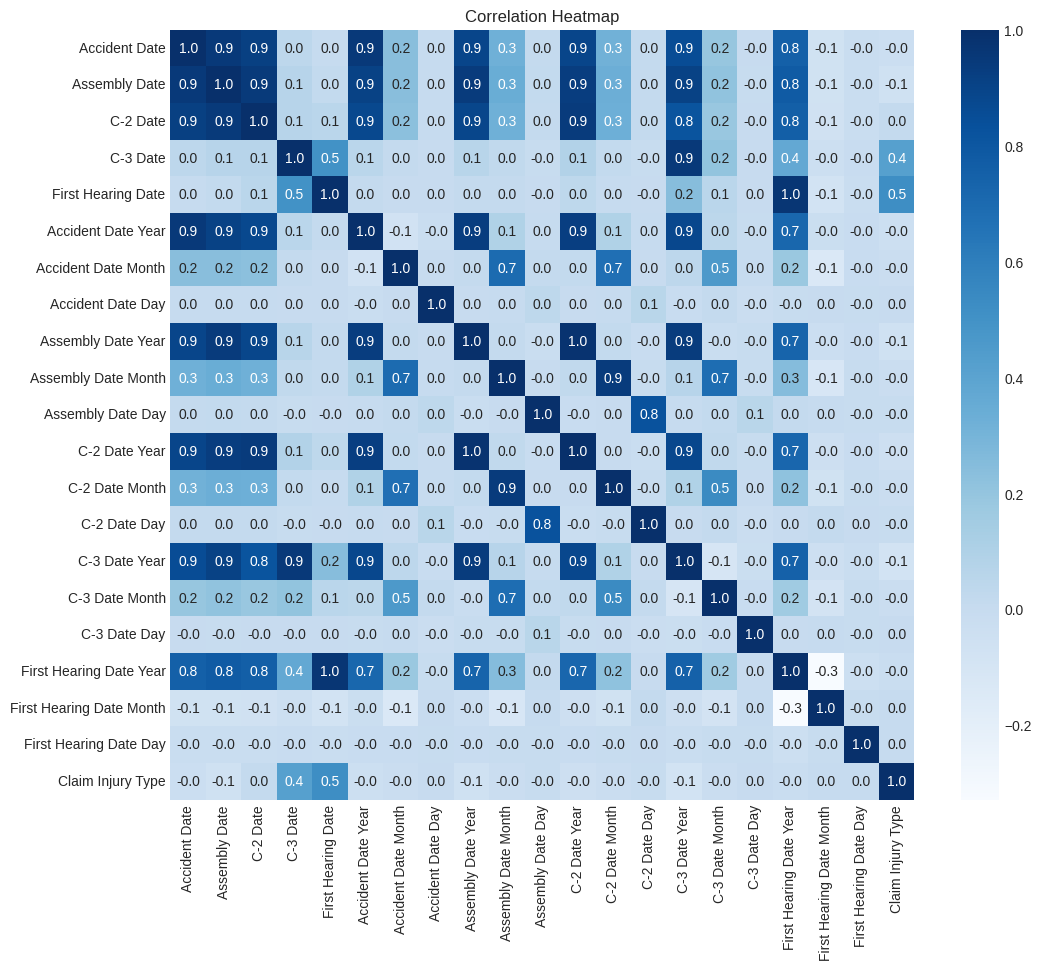

In [75]:
# Compute the correlation matrix for the date columns
corr_matrix = df_corr_dates.corr(method='spearman')

# Create the heatmap
plt.figure(figsize=(12,10))
sns.heatmap(data=corr_matrix, annot=True, cmap=plt.cm.Blues, fmt='.1f')

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

Looking at this correlation matrix, we can see that splitting the dates into its calendar components did not yield great results for target correlation. However, 'First Hearing Date' has a decent correlation with the target and we could also consider 'C-3 Date'. <br>
In addition, 'Accident Date', 'Accident Date' and 'C-2 Date' are highly correlated among themselves and with 'C-3 Date Year' and 'First Hearing Date Year'.

#### 3.3.3. Categorical features

In [79]:
df_corr_cat = df.loc[:, ~df.columns.isin(numeric_features + date_features)]

In [91]:
df_corr_cat.drop(columns=['Claim Injury Type', 'OIICS Nature of Injury Description'], inplace=True)
df_corr_cat['Claim Injury Type'] = df['Claim Injury Type'].str[0]

/tmp/ipykernel_5920/2616584262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_cat.drop(columns=['Claim Injury Type', 'OIICS Nature of Injury Description'], inplace=True)
/tmp/ipykernel_5920/2616584262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_cat['Claim Injury Type'] = df['Claim Injury Type'].str[0]


In [92]:
df_corr_cat.head()

,Alternative Dispute Resolution,Attorney/Representative,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,Gender,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents,Claim Injury Type
5393875,N,N,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,ST. LAWRENCE,N,SYRACUSE,M,44,RETAIL TRADE,I,27,FROM LIQUID OR GREASE SPILLS,10,CONTUSION,62,BUTTOCKS,13662,0,Not Work Related,1,2
5393091,N,Y,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,WYOMING,N,ROCHESTER,F,23,CONSTRUCTION,I,97,REPETITIVE MOTION,49,SPRAIN OR TEAR,38,SHOULDER(S),14569,1,Not Work Related,4,4
5393889,N,N,INDEMNITY INSURANCE CO OF,1A. PRIVATE,ORANGE,N,ALBANY,M,56,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT,II,79,OBJECT BEING LIFTED OR HANDLED,7,CONCUSSION,10,MULTIPLE HEAD INJURY,12589,0,Not Work Related,6,4
5393887,N,N,STATE INSURANCE FUND,2A. SIF,DUTCHESS,N,ALBANY,M,62,HEALTH CARE AND SOCIAL ASSISTANCE,II,16,"HAND TOOL, UTENSIL; NOT POWERED",43,PUNCTURE,36,FINGER(S),12603,0,Not Work Related,1,2
5393863,N,N,INDEMNITY INS. OF N AMERICA,1A. PRIVATE,SUFFOLK,N,HAUPPAUGE,M,44,RETAIL TRADE,IV,31,"FALL, SLIP OR TRIP, NOC",10,CONTUSION,38,SHOULDER(S),11772,0,Not Work Related,5,3


/tmp/ipykernel_5920/2701796373.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_5920/2701796373.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_5920/2701796373.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_5920/2701796373.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_5920/2701796373.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_5920/2701796373.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_5920/2701796373.py:13: RuntimeWarning: invalid va

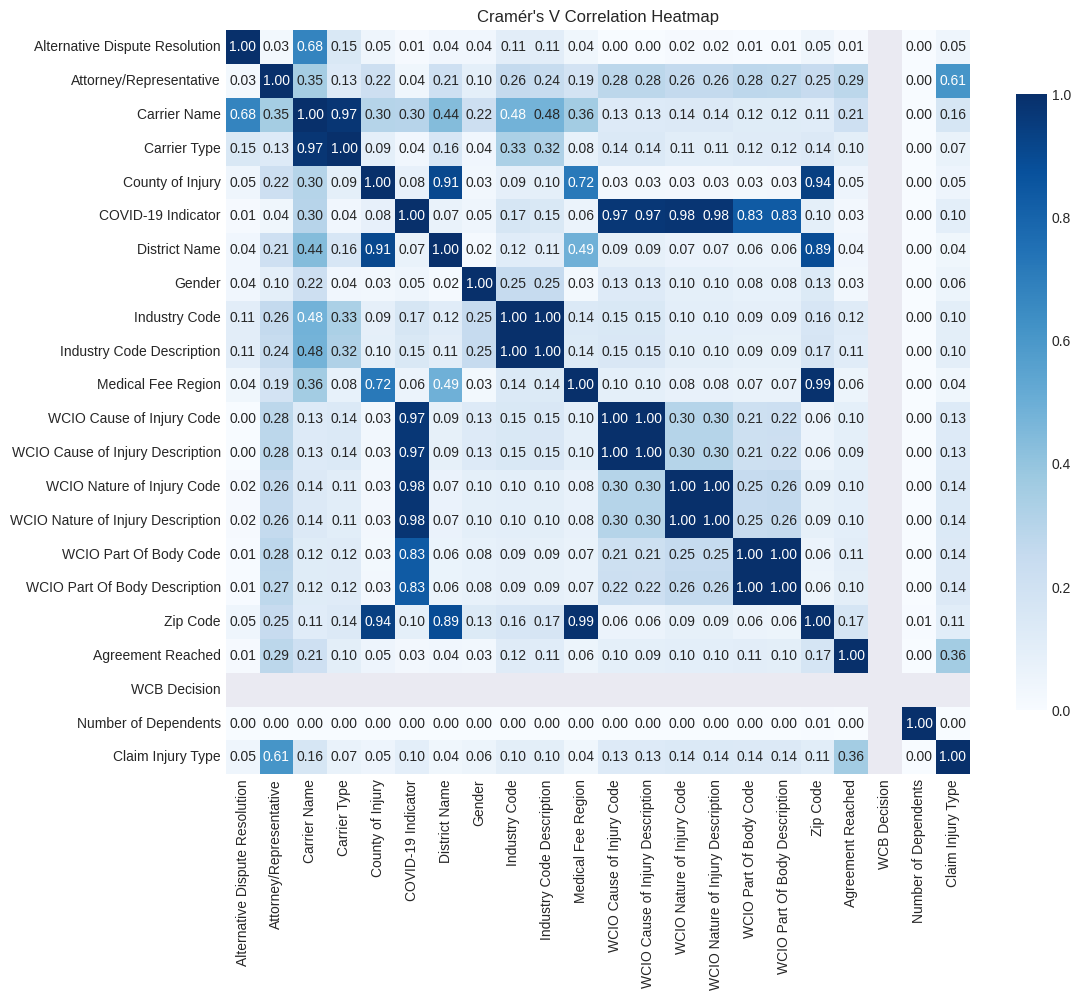

In [130]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - (r - 1) ** 2 / (n - 1)
    kcorr = k - (k - 1) ** 2 / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Get categorical features
categorical_features = df_corr_cat.columns

# Create a correlation matrix
cramers_v_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)

for col1 in categorical_features:
    for col2 in categorical_features:
        cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Convert to numeric
cramers_v_matrix = cramers_v_matrix.astype(float)

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_v_matrix, annot=True, cmap=plt.cm.Blues, square=True, cbar_kws={'shrink': .8}, fmt=".2f")
plt.title("Cramér's V Correlation Heatmap")
plt.show()

By analysing the heatmap above, we can see that 'Attoney/Representative' has a high degree of correlation with the target and, even though with a much lower value, 'Agreement Reached' is also somewhat correlated with the target.</br></br>
Some more correlations:
- 'Carrier Name' and 'Alternative Dispute Resolution' are also correlated
- 'Carrier Type' and 'Carrier Name' are almost perfectly correlated.
- 'District Name' and 'Zip Code' are highly correlated with 'County of Injury'
- 'Medical Fee Region' has a high degree of correlation with 'County of Injury'
- The WCIO codes and descriptions are highly correlated with 'COVID-19 Indicator'
- 'District Name' is highly correlated with 'Zip Code' and has some degree of correlation with 'Medical Fee Region'
- 'Medical Fee Region' and 'Zip Code' are almost perfectly correlated

### 3.4. Multivariate analysis

We will start by creating a new featue 'Days Difference' that represents the amount of days since 'Accident Date' until 'Assembly Date'

In [131]:
df['Days Difference'] = (df['Assembly Date'] - df['Accident Date']).dt.days

In [132]:
df[['Accident Date', 'Assembly Date', 'Days Difference']].head()

,Accident Date,Assembly Date,Days Difference
5393875,2019-12-30,2020-01-01,2.0
5393091,2019-08-30,2020-01-01,124.0
5393889,2019-12-06,2020-01-01,26.0
5393887,2019-12-30,2020-01-01,2.0
5393863,2019-12-26,2020-01-01,6.0


#### 3.4.1. WCIO Nature of Injury Description and Industry Code Description

In [162]:
# we remove missing values from 'WCIO Nature of Injury Description'
filtered_data = df.dropna(subset=['WCIO Nature of Injury Description'])

# we select the top 5 injuries
common_injuries = filtered_data['WCIO Nature of Injury Description'].value_counts().head(5)

In [163]:
filtered_data = filtered_data[filtered_data['WCIO Nature of Injury Description'].isin(common_injuries.index)]

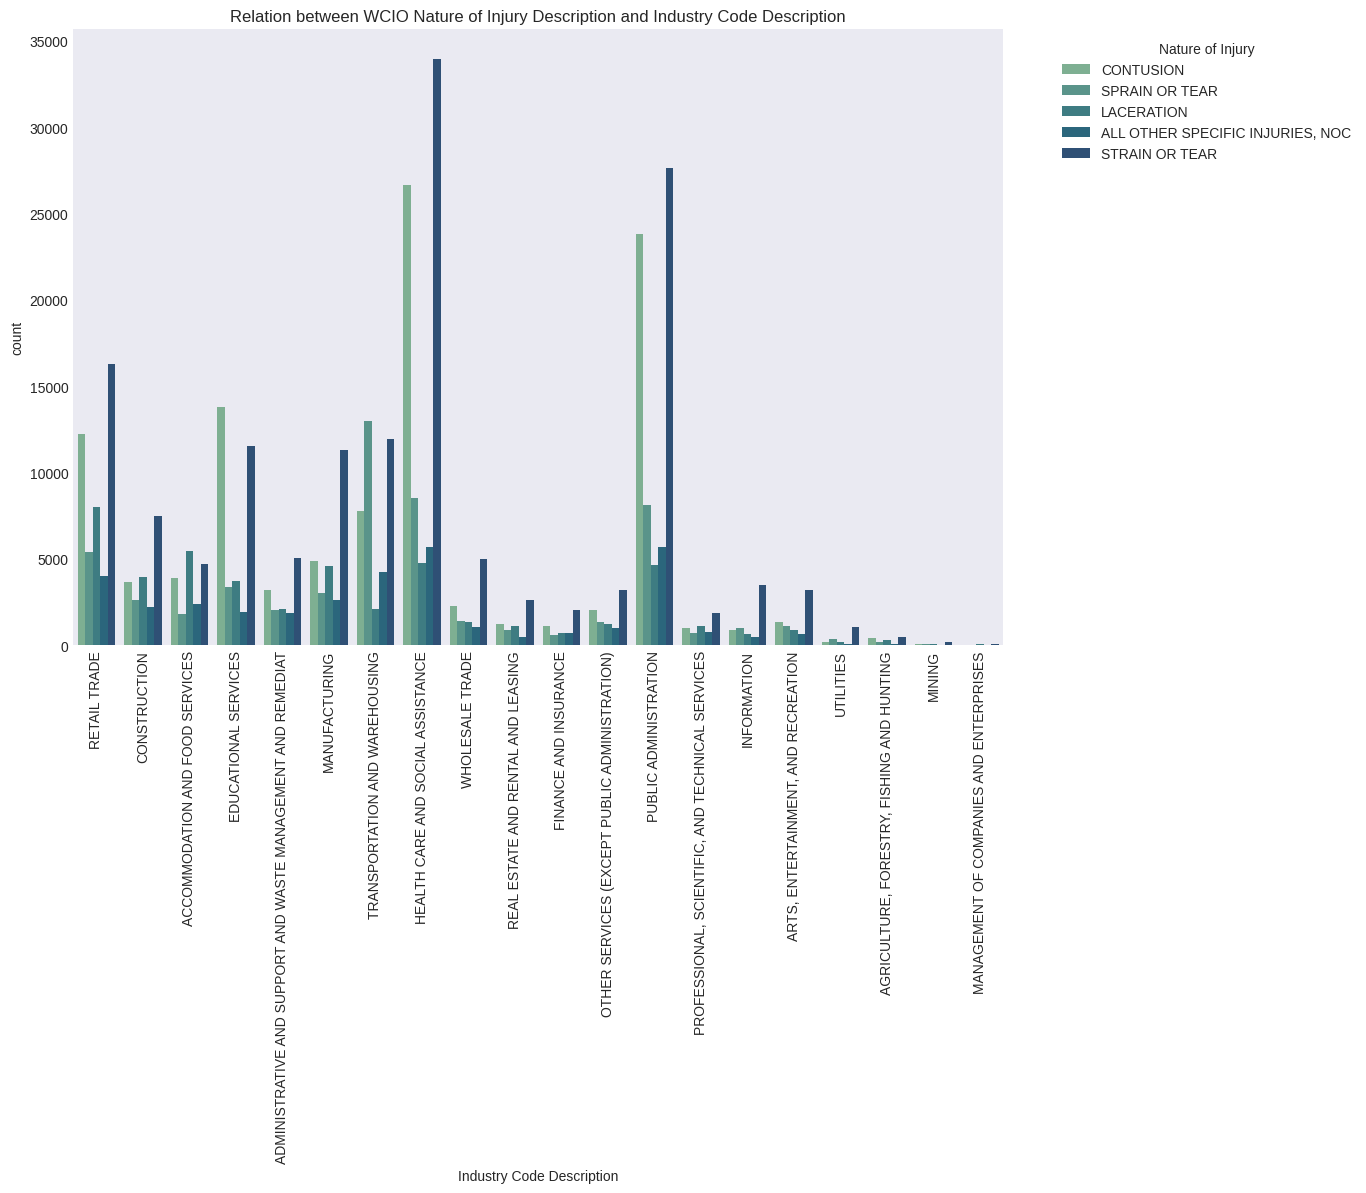

In [196]:
# Countplot for the relationship between Injuries and Industry
plt.figure(figsize=(12, 8))
sns.countplot(x='Industry Code Description', hue='WCIO Nature of Injury Description', data=filtered_data, palette="crest")
plt.title('Relation between WCIO Nature of Injury Description and Industry Code Description')
plt.xticks(rotation=90)
plt.legend(title='Nature of Injury', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/tmp/ipykernel_5920/1472652880.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WCIO Nature of Injury Description', y='Age at Injury', data=filtered_data, palette="Blues")


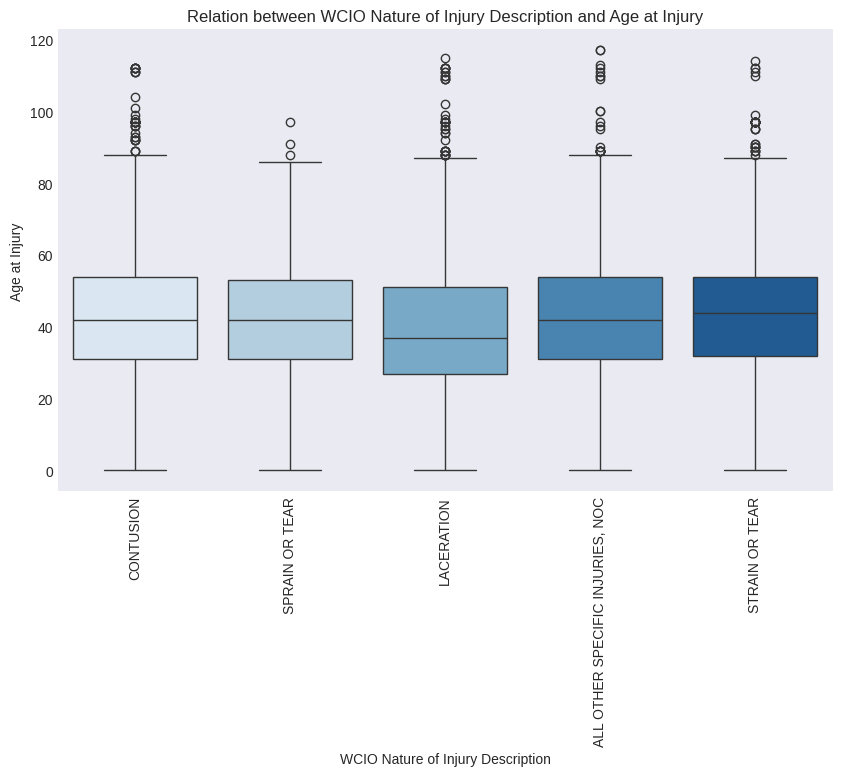

In [203]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='WCIO Nature of Injury Description', y='Age at Injury', data=filtered_data, palette="Blues")
plt.title('Relation between WCIO Nature of Injury Description and Age at Injury')
plt.xticks(rotation=90)
plt.show()

#### 3.4.2. Claim Injury Type and Attorney/Representative

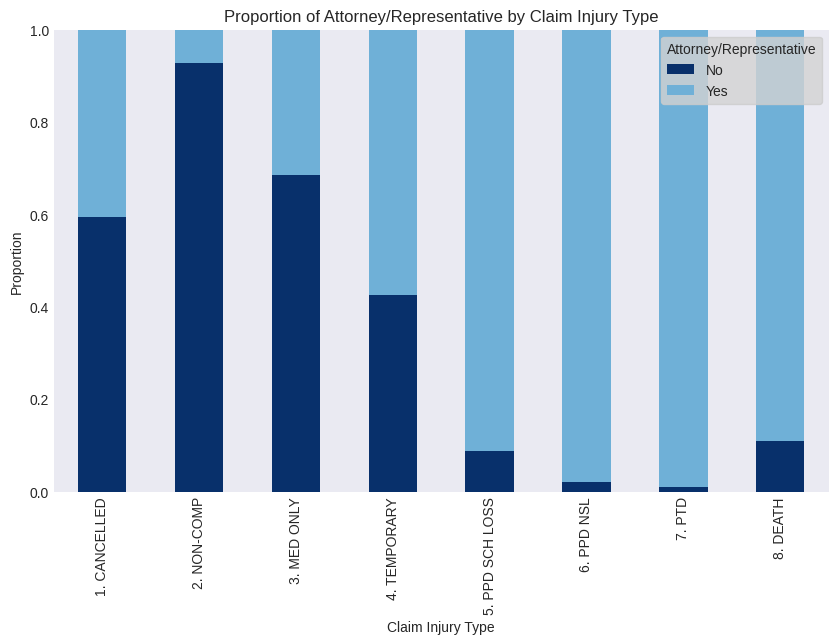

In [190]:
counts = df.groupby(['Claim Injury Type', 'Attorney/Representative']).size().unstack(fill_value=0)

# Convert counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)  # Normalize to get proportions

# Plotting
proportions.plot(kind='bar', stacked=True, color=['#08306B', '#6FB0D7'], figsize=(10, 6))

plt.title('Proportion of Attorney/Representative by Claim Injury Type')
plt.xlabel('Claim Injury Type')
plt.ylabel('Proportion')
plt.xticks(rotation=90) 

plt.legend(title='Attorney/Representative', labels=['No', 'Yes'], loc='upper right', frameon=True, facecolor='lightgray', alignment='left')

plt.ylim(0, 1)  # Set y-axis limits for percentage representation
plt.show()

#### 3.4.3. Average Weekly Wage by Attorney/Representative

/tmp/ipykernel_5920/250662816.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Attorney/Representative', y='Average Weekly Wage', data=mean_wage_by_lawyer, palette=['#08306B', '#6FB0D7'])


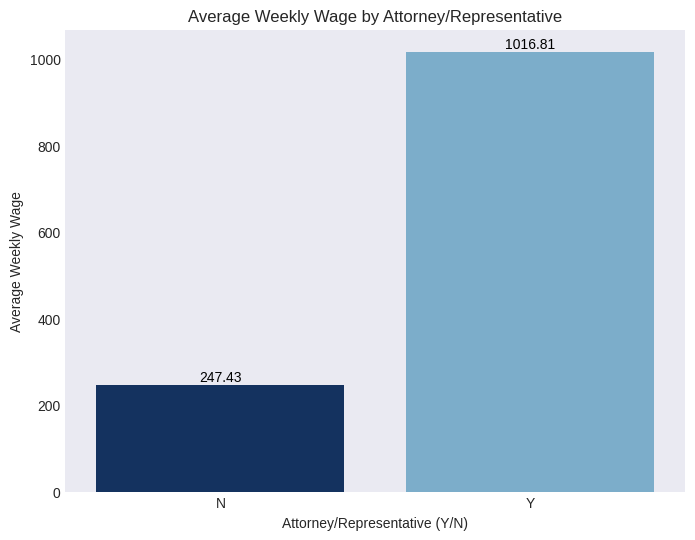

In [225]:
# Calculate the mean 'Average Weekly Wage' for each 'Attorney/Representative' category
mean_wage_by_lawyer = df.groupby('Attorney/Representative')['Average Weekly Wage'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='Attorney/Representative', y='Average Weekly Wage', data=mean_wage_by_lawyer, palette=['#08306B', '#6FB0D7'])

# Add title and labels
plt.title('Average Weekly Wage by Attorney/Representative')
plt.xlabel('Attorney/Representative (Y/N)')
plt.ylabel('Average Weekly Wage')

# Annotate the bar plot with the actual mean values
for index, row in mean_wage_by_lawyer.iterrows():
    bar_plot.text(index, row['Average Weekly Wage'], f"{row['Average Weekly Wage']:.2f}", 
                  color='black', ha="center", va="bottom")

# Show the plot
plt.show()

#### 3.4.4. Carrier Type and Claim Injury Type

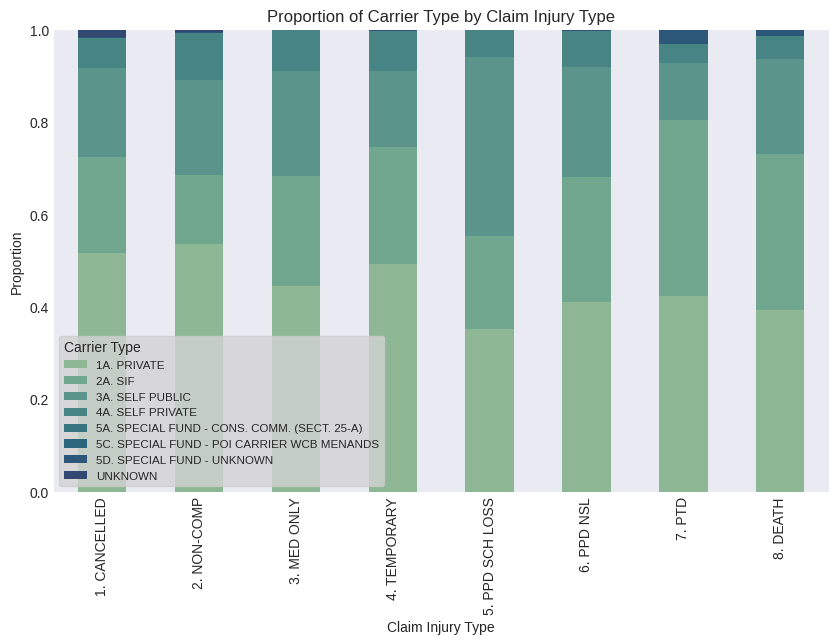

In [216]:
counts = df.groupby(['Claim Injury Type', 'Carrier Type']).size().unstack(fill_value=0)

# Convert counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)  # Normalize to get proportions

# Plotting
proportions.plot(kind='bar', stacked=True, color=['#8DB795', '#71A68F', '#5A948A', '#478484', '#367480', '#2B667C', '#2C5778', '#324871'], figsize=(10, 6))

plt.title('Proportion of Carrier Type by Claim Injury Type')
plt.xlabel('Claim Injury Type')
plt.ylabel('Proportion')
plt.xticks(rotation=90) 

plt.legend(title='Carrier Type', loc='lower left', frameon=True, facecolor='lightgray', alignment='left', fontsize='small', title_fontsize='medium')

plt.ylim(0, 1)  # Set y-axis limits for percentage representation
plt.show()

#### 3.4.5. Carrier Type and Attorney/Representative

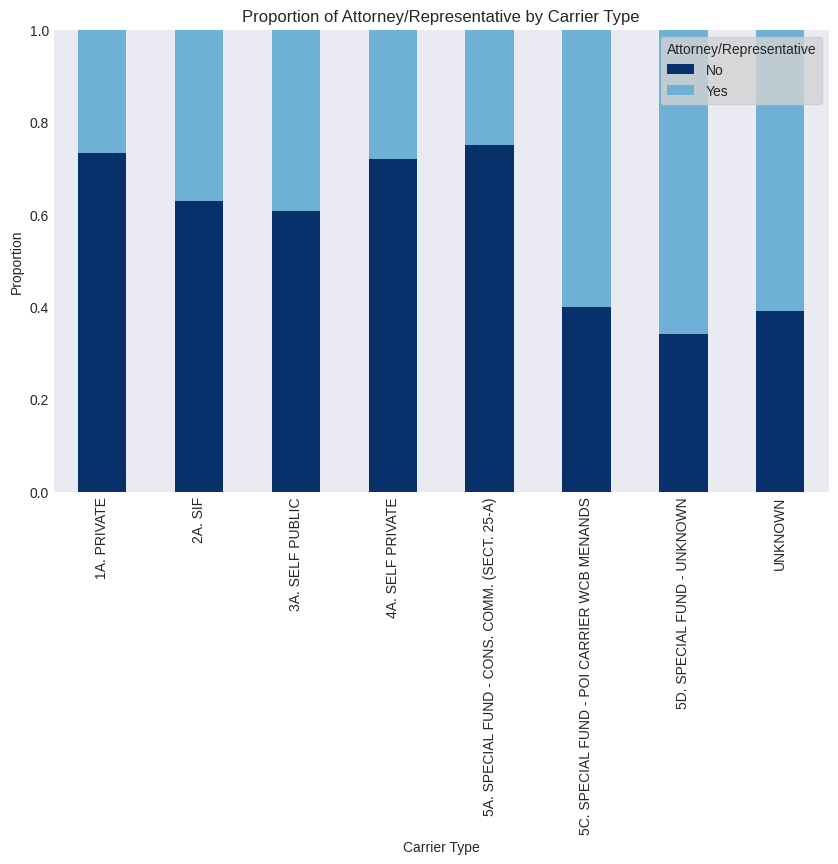

In [218]:
counts = df.groupby(['Carrier Type', 'Attorney/Representative']).size().unstack(fill_value=0)

# Convert counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)  # Normalize to get proportions

# Plotting
proportions.plot(kind='bar', stacked=True, color=['#08306B', '#6FB0D7'], figsize=(10, 6))

plt.title('Proportion of Attorney/Representative by Carrier Type')
plt.xlabel('Carrier Type')
plt.ylabel('Proportion')
plt.xticks(rotation=90) 

plt.legend(title='Attorney/Representative', labels=['No', 'Yes'], loc='upper right', frameon=True, facecolor='lightgray', alignment='left')

plt.ylim(0, 1)  # Set y-axis limits for percentage representation
plt.show()

#### 3.4.6. Claim Injury Type and COVID-19 Indicator

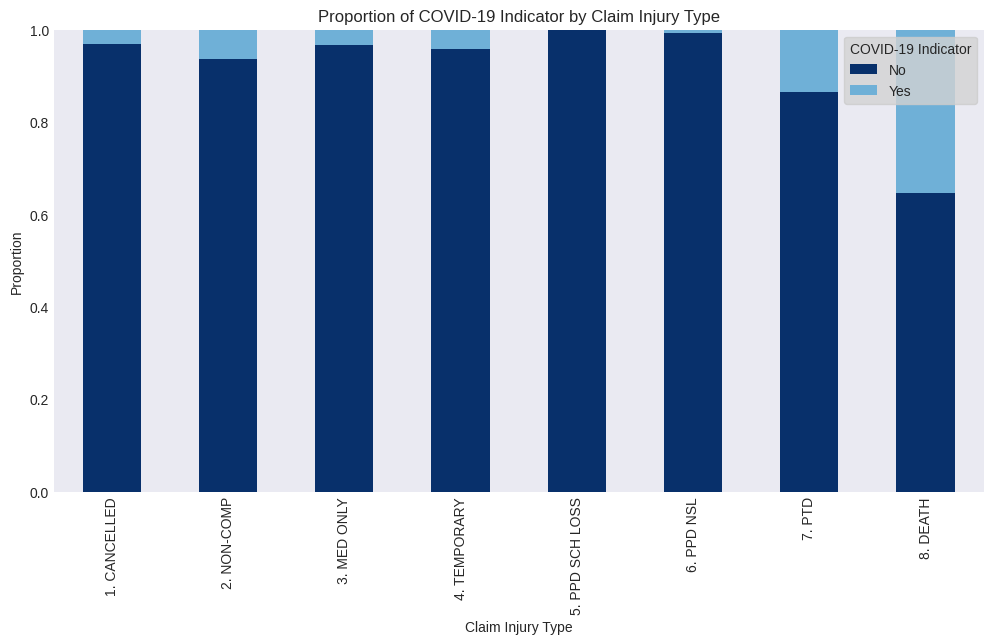

In [226]:
counts = df.groupby(['Claim Injury Type', 'COVID-19 Indicator']).size().unstack(fill_value=0)

# Convert counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)  # Normalize to get proportions

# Plotting
proportions.plot(kind='bar', stacked=True, color=['#08306B', '#6FB0D7'], figsize=(12, 6))

plt.title('Proportion of COVID-19 Indicator by Claim Injury Type')
plt.xlabel('Claim Injury Type')
plt.ylabel('Proportion')
plt.xticks(rotation=90) 

plt.legend(title='COVID-19 Indicator', labels=['No', 'Yes'], loc='upper right', frameon=True, facecolor='lightgray', alignment='left')

plt.ylim(0, 1)  # Set y-axis limits for percentage representation
plt.show()

#### 3.4.7. Average Weekly Wage and Age at Injury

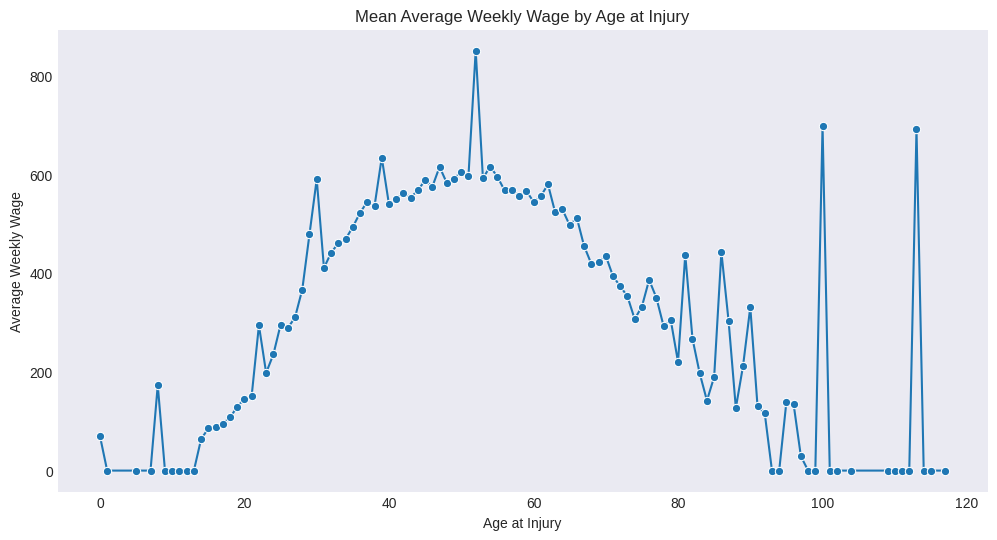

In [227]:
# Create a line plot
mean_wage_by_age = df.groupby('Age at Injury')['Average Weekly Wage'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Age at Injury', y='Average Weekly Wage', data=mean_wage_by_age, marker='o')

# Add title and labels
plt.title('Mean Average Weekly Wage by Age at Injury')
plt.xlabel('Age at Injury')
plt.ylabel('Average Weekly Wage')

# Show the plot
plt.show()

#### 3.4.8. Days Difference and Age at Injury

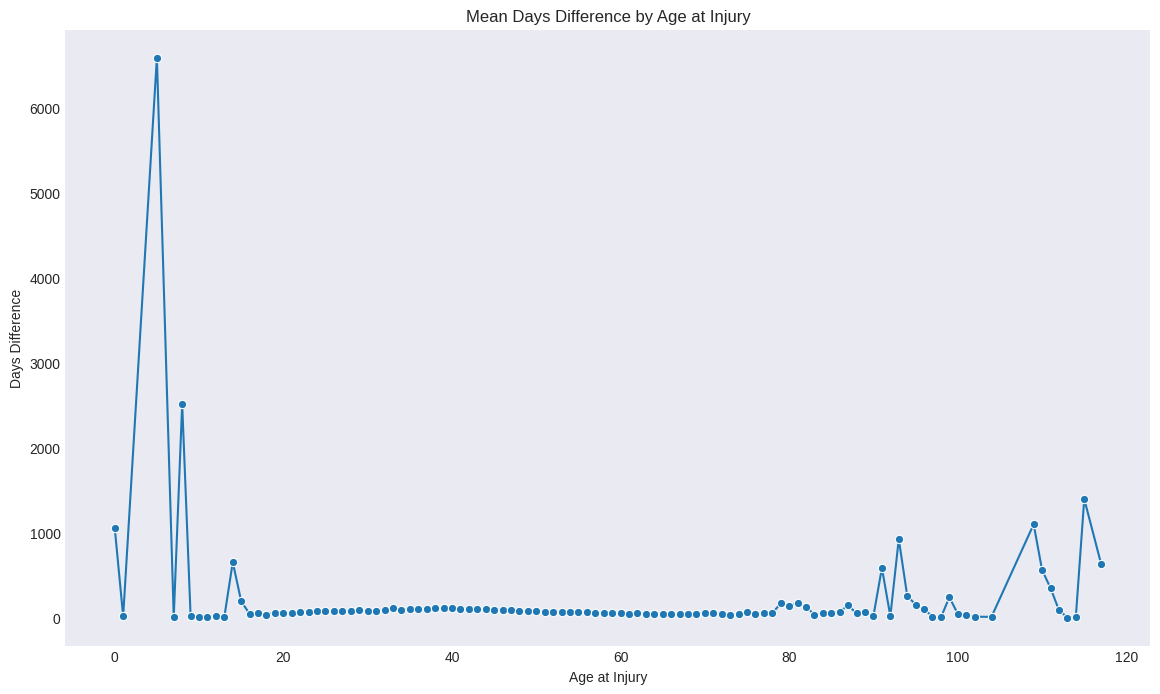

In [228]:
# Create a line plot
mean_daysdif_by_age = df.groupby('Age at Injury')['Days Difference'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='Age at Injury', y='Days Difference', data=mean_daysdif_by_age, marker='o')

# Add title and labels
plt.title('Mean Days Difference by Age at Injury')
plt.xlabel('Age at Injury')
plt.ylabel('Days Difference')

# Show the plot
plt.show()

#### 3.4.9.Days Difference and District Name

/tmp/ipykernel_5920/713950403.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='District Name', y='Days Difference', data=mean_daysdif_by_district, palette="crest")


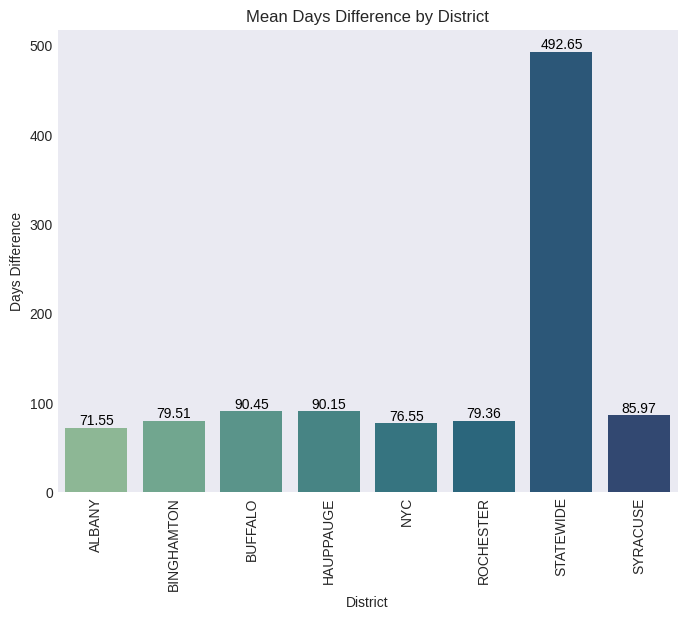

In [233]:
mean_daysdif_by_district = df.groupby('District Name')['Days Difference'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='District Name', y='Days Difference', data=mean_daysdif_by_district, palette="crest")

# Add title and labels
plt.title('Mean Days Difference by District')
plt.xlabel('District')
plt.ylabel('Days Difference')
plt.xticks(rotation=90)

# Annotate the bar plot with the actual mean values
for index, row in mean_daysdif_by_district.iterrows():
    bar_plot.text(index, row['Days Difference'], f"{row['Days Difference']:.2f}", 
                  color='black', ha="center", va="bottom")

# Show the plot
plt.show()

#### 3.4.10. Atorney/Representative and District Name

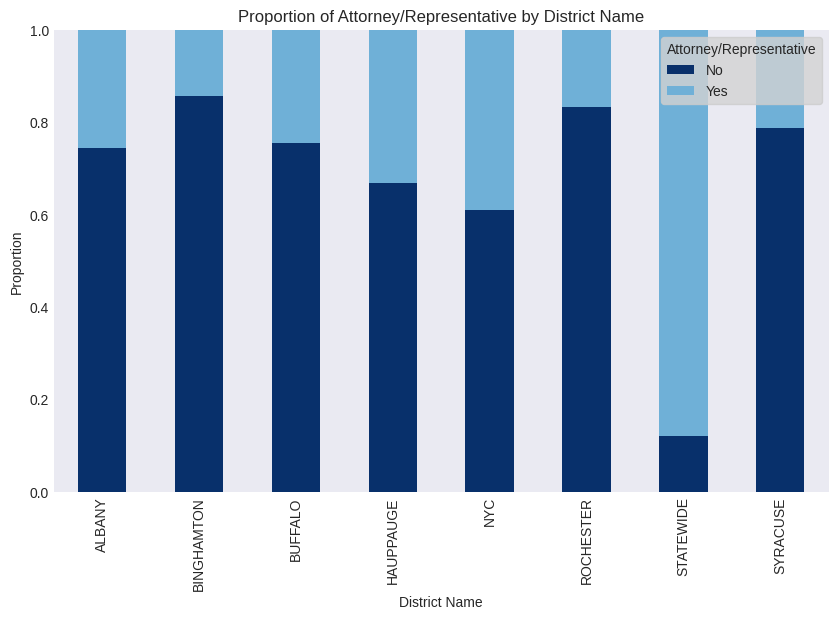

In [234]:
counts = df.groupby(['District Name', 'Attorney/Representative']).size().unstack(fill_value=0)

# Convert counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)  # Normalize to get proportions

# Plotting
proportions.plot(kind='bar', stacked=True, color=['#08306B', '#6FB0D7'], figsize=(10, 6))

plt.title('Proportion of Attorney/Representative by District Name')
plt.xlabel('District Name')
plt.ylabel('Proportion')
plt.xticks(rotation=90) 

plt.legend(title='Attorney/Representative', labels=['No', 'Yes'], loc='upper right', frameon=True, facecolor='lightgray', alignment='left')

plt.ylim(0, 1)  # Set y-axis limits for percentage representation
plt.show()

#### 3.4.11. Mean Days Difference by Attorney/Representative

/tmp/ipykernel_5920/1137432214.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Attorney/Representative', y='Days Difference', data=mean_daysdif_by_lawyer, palette=['#08306B', '#6FB0D7'])


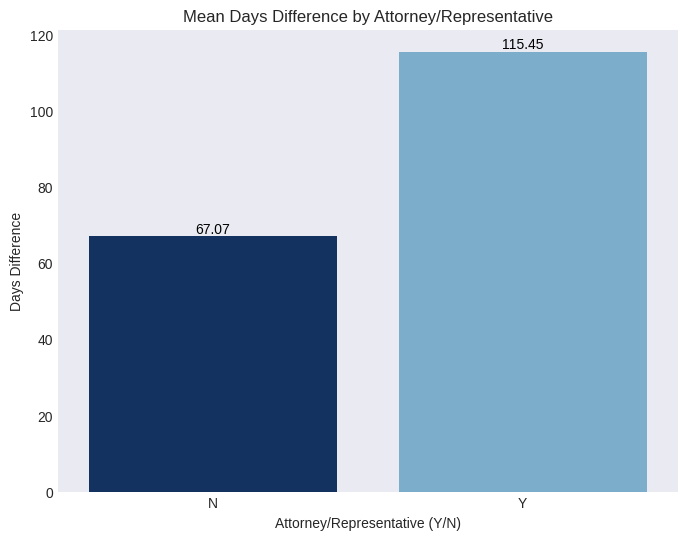

In [235]:
mean_daysdif_by_lawyer = df.groupby('Attorney/Representative')['Days Difference'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='Attorney/Representative', y='Days Difference', data=mean_daysdif_by_lawyer, palette=['#08306B', '#6FB0D7'])

# Add title and labels
plt.title('Mean Days Difference by Attorney/Representative')
plt.xlabel('Attorney/Representative (Y/N)')
plt.ylabel('Days Difference')

# Annotate the bar plot with the actual mean values
for index, row in mean_daysdif_by_lawyer.iterrows():
    bar_plot.text(index, row['Days Difference'], f"{row['Days Difference']:.2f}", 
                  color='black', ha="center", va="bottom")

# Show the plot
plt.show()

#### 3.4.12. Age at Injury and IME-4 Count

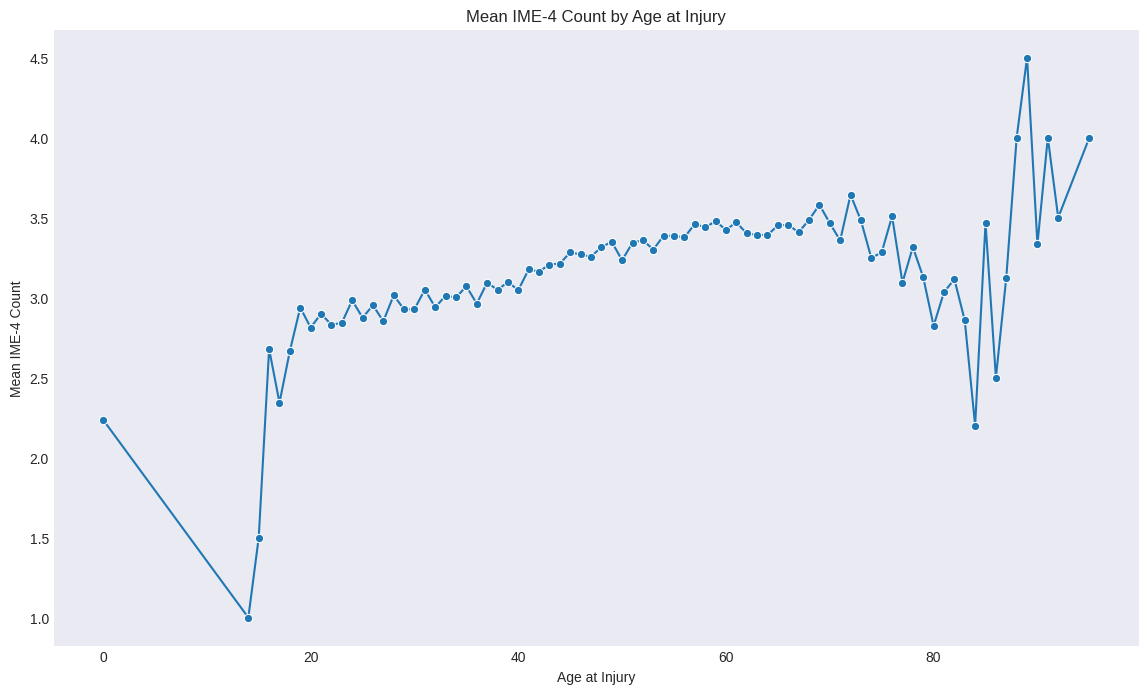

In [121]:
# Create a line plot
mean_ime_by_age = df.groupby('Age at Injury')['IME-4 Count'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='Age at Injury', y='IME-4 Count', data=mean_ime_by_age, marker='o')

# Add title and labels
plt.title('Mean IME-4 Count by Age at Injury')
plt.xlabel('Age at Injury')
plt.ylabel('Mean IME-4 Count')

# Show the plot
plt.show()